In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
from Sequence import Sequence
from matplotlib.patches import Rectangle
from skimage import io
from utils import get_subwindow, get_scale_subwindow
import os
from pyhog import pyhog

<Figure size 432x288 with 0 Axes>

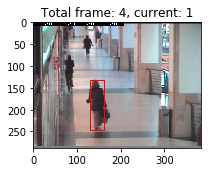

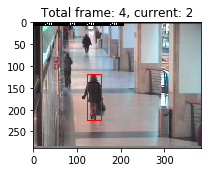

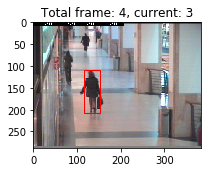

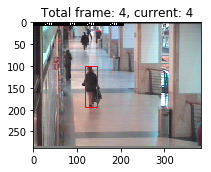

In [2]:
# Visualize Sequence 

sequence = Sequence(path = os.getcwd(), name='tutorials/img_ScaleChange', 
                    region_format='rectangle')
plt.clf()

while sequence._frame < len(sequence._images):
    
    img = io.imread(sequence.frame())
    
    data = sequence.groundtruth[sequence._frame]
    gt_rect = Rectangle(
            xy=(data.x, data.y),
            width=data.width,
            height=data.height,
            facecolor='none',
            edgecolor='r',
    )
    plt.figure(figsize=(3,3))
    tracking_figure_axes = plt.subplot(111)
    tracking_figure_axes.add_patch(gt_rect)
    plt.imshow(img)
    plt.title('Total frame: %d, current: %d' % (len(sequence._images), 
                                                sequence._frame+1))
    
    sequence._frame += 1
    
sequence._frame = 0 # after that, we must reset the sequence

In [3]:
padding = 1.0 # 用来设定 target size 的倍数

output_sigma_factor = 1/float(16) # the desired correlation output to 1/16 
                                  # of target size for the translation filter
scale_sigma_factor = 1/float(4)   # 0.25 in the scaler filter 论文貌似中是1.5

lamda = 1e-2
lamda_scale = 1e-2 # 貌似没用

interp_factor = 0.025 # 学习率，论文中的 以她,本代码没用过，==！

nScales = 33 # number of scale levels

scale_model_factor = 1.0 
scale_step = 1.02 # step of one scale level，论文中的 a
scale_model_max_area = 32*16

scaleFactors used for scale estimation:
[1.37278571 1.34586834 1.31947876 1.29360663 1.26824179 1.24337431
 1.21899442 1.19509257 1.17165938 1.14868567 1.12616242 1.1040808
 1.08243216 1.061208   1.0404     1.02       1.         0.98039216
 0.96116878 0.94232233 0.92384543 0.90573081 0.88797138 0.87056018
 0.85349037 0.83675527 0.8203483  0.80426304 0.78849318 0.77303253
 0.75787502 0.74301473 0.72844581] 

Gaussian shaped vector for scale estimation:
[1.11537587e-27 2.04743479e-24 2.31436520e-21 1.61096714e-18
 6.90517119e-16 1.82261608e-13 2.96243564e-11 2.96507462e-09
 1.82749127e-07 6.93598224e-06 1.62103956e-04 2.33298653e-03
 2.06758717e-02 1.12836187e-01 3.79197929e-01 7.84723194e-01
 1.00000000e+00 7.84723194e-01 3.79197929e-01 1.12836187e-01
 2.06758717e-02 2.33298653e-03 1.62103956e-04 6.93598224e-06
 1.82749127e-07 2.96507462e-09 2.96243564e-11 1.82261608e-13
 6.90517119e-16 1.61096714e-18 2.31436520e-21 2.04743479e-24
 1.11537587e-27] 

Gaussian shaped matrix for location:


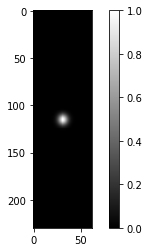

In [4]:
# get image, region and target Gaussian shape for training

img_raw = io.imread(sequence.frame()) 

data = sequence.groundtruth[sequence._frame]
X = data.x
Y = data.y
width = data.width
height = data.height
target_size = [height, width]
target_size = np.array(target_size)
pos = [Y+height/2.,X+width/2.]
# target_size 是目标框高和宽，pos 代表中点位置，都是二元组

###############################################################

init_target_size = target_size
currentScaleFactor = 1.0
base_target_size = target_size / currentScaleFactor
sz = np.floor(base_target_size * (1 + padding)) # target_size 高宽二元组的 （1 + padding）倍

###############################################################
# Gaussian shaped label for location

output_sigma = np.sqrt(np.prod(target_size)) * output_sigma_factor
# sqrt(height × width) * 1/16

scale_sigma = np.sqrt(nScales) * scale_sigma_factor
# sqrt(33) * 1/4

grid_y = np.arange(np.floor(sz[0])) - np.floor(sz[0]/2)
grid_x = np.arange(np.floor(sz[1])) - np.floor(sz[1]/2)
rs, cs = np.meshgrid(grid_x, grid_y)
y = np.exp(-0.5 / output_sigma ** 2 * (rs ** 2 + cs ** 2))
# y 是一个二维高斯分布，最高点的位置在中心。两坐标是 sz 的二元组



###############################################################
# Gaussian shaped label for scale estimation

ss = np.arange(nScales) - np.ceil(nScales/2)
ys = np.exp(-0.5 * (ss ** 2) / scale_sigma ** 2)
# 与上面的 y 类似，只不过是一维的

scaleFactors = np.power(scale_step, -ss) # 从大到小排列的 33 个数字
# 33个数，为什么是负的呢？干嘛用的呢？？？？？？？？？？？？？？？


###############################################################
# 输出与可视化

print 'scaleFactors used for scale estimation:'
print scaleFactors,'\n'
print 'Gaussian shaped vector for scale estimation:'
print ys,'\n'
print 'Gaussian shaped matrix for location:'
plt.imshow(y,cmap=plt.cm.gray)
plt.colorbar()

# yf,ysf 分别表示位置和大小估计的傅里叶变换，只在初始化分子和分母的时候要用
yf = np.fft.fft2(y, axes=(0,1)) # y 是二维的，对全体平面做变换 shape: 230 * 62，目标位置回归矩阵
ysf = np.fft.fft(ys) # ys 一维，直接变换 shape:33，目标尺度回归矩阵


In [9]:
# preprocess (get subwindow, extract feature, add cosine window, fft...)


# position search preprocess。在原图中，根据中心位置，选择一个 sz 大的区域，特征hog。注意是 sz 大的
feature_map = get_subwindow(img_raw, pos, sz, feature='hog')
# feature_map shape : 230 * 62 * 31

# 根据 sz 的两坐标长度，生成cos_window，中间高，周围低,shape : 230 * 62。百度 “相关滤波里余弦窗作用”
cos_window = np.outer(np.hanning(y.shape[0]), np.hanning(y.shape[1]))

# hog 特征与 cos_window 乘法 
x_hog = np.multiply(feature_map, cos_window[:, :, None])
# x_hog shape : 230 * 62 * 31

xf = np.fft.fft2(x_hog, axes=(0,1))
# xf shape : 230 * 62 * 31，目标位置候选窗口的特征

# scale search preprocess,scale_window 是中间大，两边小的 33 个数
if nScales%2 == 0:
    scale_window = np.hanning(nScales+1)
    scale_window = scale_window[1:]
else:
    scale_window = np.hanning(nScales)
   
scaleSizeFactors = scaleFactors # 33 个数

min_scale_factor = np.power(scale_step,
                            np.ceil(np.log(5./np.min(sz))/np.log(scale_step)))

max_scale_factor = np.power(scale_step,
                            np.floor(np.log(np.min(np.divide(img_raw.shape[:2],
                                     base_target_size)))
                                     /np.log(scale_step)))

# 不大明白！！！！！！！！！！！！！！
if scale_model_factor*scale_model_factor*np.prod(init_target_size)>scale_model_max_area:
    scale_model_factor = np.sqrt(scale_model_max_area/np.prod(init_target_size))
# scale_model_factor : 0.37897033303938604

scale_model_sz = np.floor(init_target_size * scale_model_factor)
# scale_model_sz : [41,33]

###############################################################

#def get_scale_subwindow(im,pos,base_target_size, scaleFactors,scale_window, scale_model_sz)

# currentScaleFactor : 1.0
# scaleSizeFactors shape : 33
# scale_model_sz : [43. 11.]
# scale_window shape : 33
# s shape : 33 * 279
# base_target_size = target_size : [115. 31.]

# get_scale_subwindow 获得不同尺寸下的特征图的平铺
s = get_scale_subwindow(img_raw,pos,base_target_size,
                        currentScaleFactor * scaleSizeFactors,scale_window,
                        scale_model_sz)
# shape : 33 * 279

###############################################################

# 只在初始化分子和分母的时候要用
sf = np.fft.fftn(s, axes=[0]) 
# sf shape : 33 * 279， n个特征的傅里叶域。33个尺度 boundingBox，每个有279个特征,注意 axes的值


(230, 62)


In [6]:
# training and filter initialization (mosse 论文)
# 初始的值其实就是以第一帧图的 boundingBox 建立的分布模型，包括位置和尺度。

x_num = np.multiply(yf[:,:, None], np.conj(xf))
x_den = np.real(np.sum(np.multiply(xf, np.conj(xf)), axis=2))


s_num = np.multiply(ysf[:, None], np.conj(sf))
s_den = np.real(np.sum(np.multiply(sf, np.conj(sf)), axis=1))


In [7]:
# detecting

###############################################################

# 第一帧的 groudtruth 信息，添加到数组里
pos_list = []
pos_list.append(pos-base_target_size*currentScaleFactor/2.)
scale_list = []
scale_list.append(base_target_size)

###############################################################

print 'frame:',sequence._frame+1,'original position:',\
    pos-base_target_size*currentScaleFactor/2.
print 'frame:',sequence._frame+1,'original scale:',\
        base_target_size*currentScaleFactor

###############################################################

# 本代码分子分母没有更新
while sequence._frame < len(sequence._images)-1:

    ###############################################################
    # position search
    sequence._frame += 1
    test_img = io.imread(sequence.frame())
    test_patch = get_subwindow(test_img, pos, sz, scale_factor=currentScaleFactor)

    
    hog_feature_t = pyhog.features_pedro(test_patch/255., 1)
       
    hog_feature_t = np.lib.pad(hog_feature_t, ((1, 1),(1, 1),(0,0)), 'edge')
    

    
    xt = np.multiply(hog_feature_t, cos_window[:, :, None])
    xtf = np.fft.fft2(xt,axes=(0,1))

    
    response = np.real(np.fft.ifft2(np.divide(np.sum(np.multiply(x_num, xtf),
                                                 axis=2),(x_den+lamda))))
    # response : 230 * 62
    
    v_centre, h_centre = np.unravel_index(response.argmax(), response.shape)
    
    vert_delta, horiz_delta = \
        [(v_centre - response.shape[0] / 2)*currentScaleFactor,
        (h_centre - response.shape[1] / 2)*currentScaleFactor]

    
    pos = [pos[0] + vert_delta, pos[1] + horiz_delta]
    print 'frame:',sequence._frame+1,'predicted position:',\
        pos-base_target_size*currentScaleFactor/2.
    pos_list.append(pos-base_target_size*currentScaleFactor/2.)

    ###############################################################
    # scale search
    
    st = get_scale_subwindow(test_img,pos,base_target_size,
                        currentScaleFactor * scaleSizeFactors,scale_window,
                        scale_model_sz)

    stf = np.fft.fftn(st, axes=[0])

    # s_num shape : 33 * 279
    # stf shape : 33 * 279
    # scale_response shape : 33
    # s_den shape : 33
    
#     scale_reponse = np.real(np.fft.ifftn(np.sum(np.divide(np.multiply(s_num, stf),
#           (s_den[:, None] + lamda_scale)), axis=1)))
    
    
    scale_reponse = np.real(np.fft.ifftn(np.divide(
        np.sum(np.multiply(s_num,stf),axis=1),s_den+lamda_scale)))
    
    recovered_scale = np.argmax(scale_reponse)
    currentScaleFactor = currentScaleFactor * scaleFactors[recovered_scale]
    print 'frame:',sequence._frame+1,'predicted scale:',\
        base_target_size*currentScaleFactor
    scale_list.append(base_target_size*currentScaleFactor)

    if currentScaleFactor < min_scale_factor:
        currentScaleFactor = min_scale_factor
    elif currentScaleFactor > max_scale_factor:
        currentScaleFactor = max_scale_factor
        
###############################################################
        
sequence._frame = 0

frame: 1 original position: [132. 130.]
frame: 1 original scale: [115.  31.]
frame: 2 predicted position: [115. 124.]
frame: 2 predicted scale: [112.74509804  30.39215686]
frame: 3 predicted position: [106.32352941 120.38235294]
frame: 3 predicted scale: [110.53440984  29.79623222]
frame: 4 predicted position: [ 91.08900423 116.83564014]
frame: 4 predicted scale: [108.36706847  29.21199237]


predit result (green box) and groundtruth (red box)


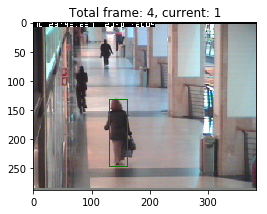

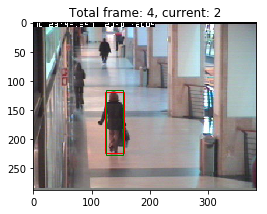

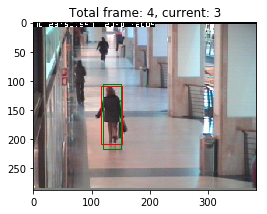

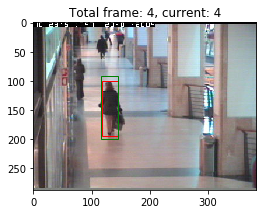

In [8]:
# visualize the result

print 'predit result (green box) and groundtruth (red box)'
while sequence._frame < len(sequence._images):
    img = io.imread(sequence.frame())
    
    data = sequence.groundtruth[sequence._frame]
    gt_rect = Rectangle(
            xy=(data.x, data.y),
            width=data.width,
            height=data.height,
            facecolor='none',
            edgecolor='r',
    )
    pd_rect = Rectangle(
            xy=(pos_list[sequence._frame][1], pos_list[sequence._frame][0]),
            width=scale_list[sequence._frame][1],
            height=scale_list[sequence._frame][0],
            facecolor='none',
            edgecolor='g',
    )
    plt.figure(figsize=(4,4))
    tracking_figure_axes = plt.subplot(111)
    tracking_figure_axes.add_patch(gt_rect)
    tracking_figure_axes.add_patch(pd_rect)
    plt.imshow(img)
    plt.title('Total frame: %d, current: %d' % (len(sequence._images), 
                                                sequence._frame+1))
    
    sequence._frame += 1
    
sequence._frame = 0 # after that, we must reset the sequence